<a href="https://colab.research.google.com/github/mukulre/Projects/blob/main/Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np

In [7]:
from fastai.vision.all import * # or from fastai.vision import * if using an older version of fastai

x  = r'/content/drive/MyDrive/Pneumonia Detection'
path = Path(x) # Convert the string path to a Path object
path.ls()

(#1) [Path('/content/drive/MyDrive/Pneumonia Detection/chest_xray')]

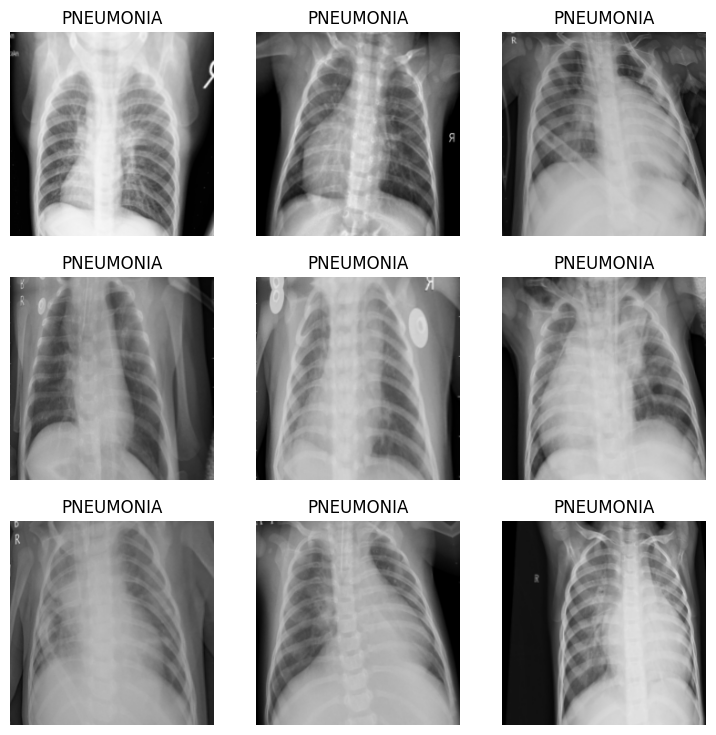

In [8]:
np.random.seed(40)
data = ImageDataLoaders.from_folder(path, train = '.', valid_pct=0.2,
                                  item_tfms=Resize(224, method='squish'),batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)],
                                  num_workers=4)
data.show_batch()

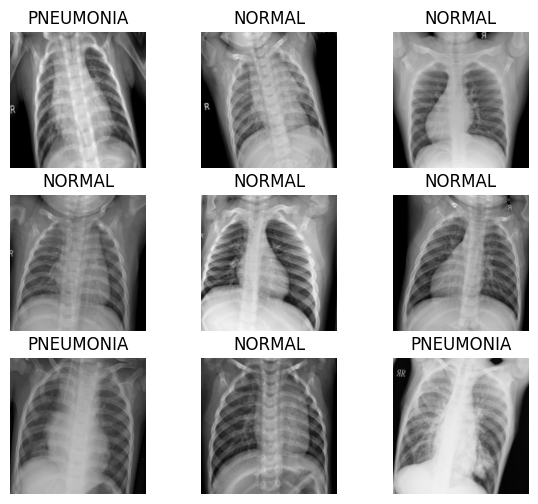

In [6]:
data.show_batch(nrows=3,max_n=9, figsize=(7,6))

In [9]:
from fastai.vision.all import *
learn = vision_learner(data, models.resnet50, metrics=[accuracy], model_dir = Path('Path'),path = Path("."))

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **torch_load_kwargs

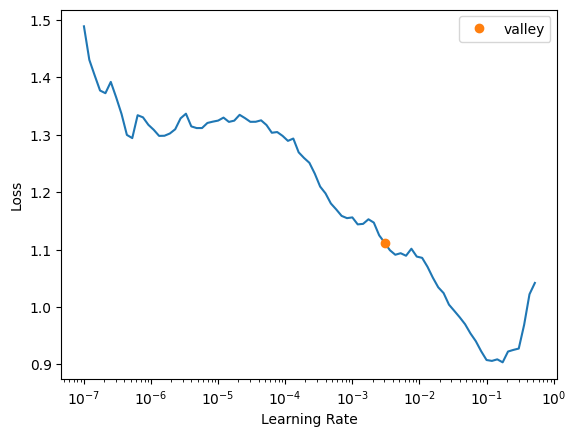

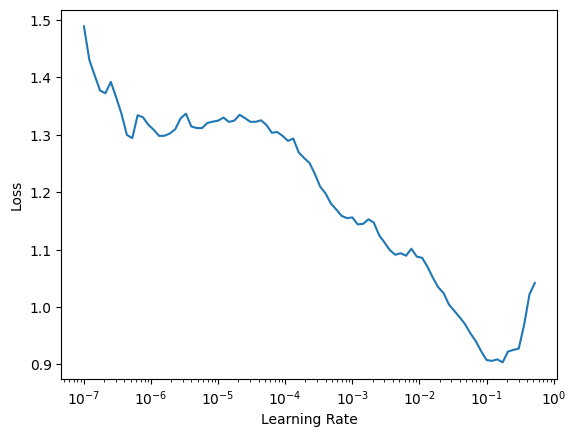

In [8]:
learn.lr_find()
learn.recorder.plot_lr_find()

In [ ]:
# Use a smaller model (resnet34 instead of resnet50)
learn = vision_learner(data, resnet34, metrics=accuracy)

# Enable mixed precision training for faster computation
learn = learn.to_fp16()

# Simplified learning rate schedule
lr = 1e-2  # Single learning rate instead of slice

# Reduced epochs (4 → 2, 20 → 5, 10 → 3)
learn.fit_one_cycle(2, lr)  # Initial training

learn.unfreeze()
learn.fit_one_cycle(3, slice(1e-4, 1e-2))  # Fine-tuning

# Optional: Remove plotting to save time
# learn.recorder.plot_losses()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 130MB/s]
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.11/dist-packages/torch/amp/gra

epoch,train_loss,valid_loss,accuracy,time


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
img = open_image('IM-0001-0001.jpeg')
print(learn.predict(img)[0])